# Ungraded Lab: Variational Autoencoders

## Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display

2024-07-30 13:48:45.714075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 13:48:45.714186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 13:48:45.846861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Parameters

In [2]:
# Define global constants to be used in this notebook
BATCH_SIZE=128
LATENT_DIM=2

## Prepare the Dataset

In [3]:
def map_image(image, label):
  '''returns a normalized and reshaped tensor from a given image'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(28, 28, 1,))
  
  return image

In [4]:
def get_dataset(map_fn, is_validation=False):
  '''Loads and prepares the mnist dataset from TFDS.'''
  if is_validation:
    split_name = "test"
  else:
    split_name = "train"

  dataset = tfds.load('mnist', as_supervised=True, split=split_name)
  dataset = dataset.map(map_fn)
  
  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

  return dataset

In [5]:
train_dataset = get_dataset(map_image)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Build the Model

### Sampling Class

In [6]:
# Define a custom Sampling layer that implements the reparameterization trick
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mu, sigma = inputs  # Unpack the mean and standard deviation
        batch = tf.shape(mu)[0]  # Get the batch size
        dim = tf.shape(mu)[1]  # Get the dimensionality of the latent space
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))  # Generate random noise
        return mu + tf.exp(0.5 * sigma) * epsilon  # Combine mean, std deviation, and noise to sample z

### Encoder

In [7]:
# Function to define the layers of the encoder
def encoder_layers(inputs, latent_dim):
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv1")(inputs)  # First convolutional layer
    x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv2")(x)  # Second convolutional layer
    batch_2 = tf.keras.layers.BatchNormalization()(x)  # Batch normalization
    x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)  # Flatten the feature maps
    x = tf.keras.layers.Dense(20, activation='relu', name="encode_dense")(x)  # Dense layer with 20 units
    x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization
    mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)  # Dense layer to output the mean of the latent space
    sigma = tf.keras.layers.Dense(latent_dim, name ='latent_sigma')(x)  # Dense layer to output the log variance of the latent space
    return mu, sigma, batch_2.shape  # Return the mean, log variance, and shape of the feature maps

In [8]:
# Function to build the encoder model
def encoder_model(latent_dim, input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)  # Input layer with the given shape
    mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=latent_dim)  # Get the outputs of the encoder layers
    z = Sampling()((mu, sigma))  # Sample z using the Sampling layer
    model = tf.keras.Model(inputs, outputs=[mu, sigma, z])  # Define the encoder model
    return model, conv_shape  # Return the encoder model and the shape of the feature maps

### Decoder

In [9]:
# Function to define the layers of the decoder
def decoder_layers(inputs, conv_shape):
    units = conv_shape[1] * conv_shape[2] * conv_shape[3]  # Compute the number of units for the Dense layer
    x = tf.keras.layers.Dense(units, activation='relu', name="decode_dense1")(inputs)  # Dense layer to expand the latent space
    x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization
    x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)  # Reshape to the shape of the feature maps
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)  # First transposed convolutional layer
    x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_3")(x)  # Second transposed convolutional layer
    x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x)  # Final transposed convolutional layer
    return x  # Return the output of the decoder

In [10]:
# Function to build the decoder model
def decoder_model(latent_dim, conv_shape):
    inputs = tf.keras.layers.Input(shape=(latent_dim,))  # Input layer with the shape of the latent space
    outputs = decoder_layers(inputs, conv_shape)  # Get the output of the decoder layers
    model = tf.keras.Model(inputs, outputs)  # Define the decoder model
    return model  # Return the decoder model

### Kullback–Leibler Divergence

In [11]:
# Define a custom KLLossLayer to compute the KL divergence loss
class KLLossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        mu, sigma = inputs  # Unpack the mean and log variance
        kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)  # Compute the KL divergence
        kl_loss = tf.reduce_mean(kl_loss) * -0.5  # Compute the mean KL divergence
        self.add_loss(kl_loss)  # Add the KL divergence loss to the layer
        return inputs  # Return the inputs

### VAE Model

In [12]:
# Function to build the VAE model
def vae_model(encoder, decoder, input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)  # Input layer with the given shape
    mu, sigma, z = encoder(inputs)  # Get the outputs of the encoder
    reconstructed = decoder(z)  # Get the reconstructed output from the decoder
    kl_loss_layer = KLLossLayer()([mu, sigma])  # Compute the KL divergence loss
    model = tf.keras.Model(inputs=inputs, outputs=reconstructed)  # Define the VAE model
    return model  # Return the VAE model

In [13]:
# Function to get the encoder, decoder, and VAE models
def get_models(input_shape, latent_dim):
    encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)  # Build the encoder model
    decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)  # Build the decoder model
    vae = vae_model(encoder, decoder, input_shape=input_shape)  # Build the VAE model
    return encoder, decoder, vae  # Return the encoder, decoder, and VAE models

In [14]:
# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, vae = get_models(input_shape=(28, 28, 1), latent_dim=LATENT_DIM)  # Get the models with the specified input shape and latent dimensionality

In [15]:
# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [16]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


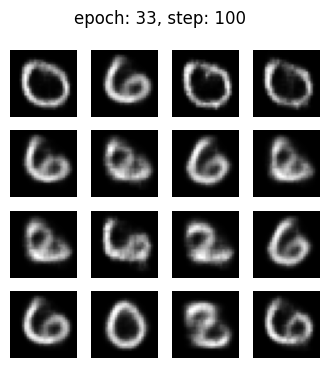

Epoch: 33 step: 100 mean loss = 146.74377


In [ ]:
# Training loop. 

# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 100

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:

      # feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784
      
      # add KLD regularization loss
      loss += sum(vae.losses)  

    # get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))